In [10]:
from data_reading import x_train, y_train,x_test, y_test
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import logging
from tensorflow import get_logger

In [11]:
x_test,x_train = np.array(x_test),np.array(x_train)
y_test,y_train = np.array(y_test),np.array(y_train)

print(y_train.shape)  # Expected: (60000,)
print(y_test.shape)  # Expected: (10000,)

# Reshape the data if necessary
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("After one hot encoding:")
print(y_train.shape)  # Expected: (60000,)
print(y_test.shape)  # 


(60000,)
(10000,)
After one hot encoding:
(60000, 10)
(10000, 10)


In [12]:
import GPyOpt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

X_train,y_train, X_test, y_test = x_train, y_train, x_test, y_test

print(X_train.shape)  # Should be (60000, 784)
print(y_train.shape)  # Should be (60000, 10)
print(X_test.shape)   # Should be (10000, 784)
print(y_test.shape)   # Should be (10000, 10)

X_train = X_train.reshape(-1, 784)  # Reshape to (60000, 784)
X_test = X_test.reshape(-1, 784)

# Define the domain of the considered parameters
domain = [{'name': 'num_hidden_layers', 'type': 'discrete', 'domain': (1, 2, 3,4,5,6,7,8,9,10)},
          {'name': 'neurons_per_layer', 'type': 'discrete', 'domain': (16, 32, 64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 0.01)}]


(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [15]:
import random
def create_mlp_model(num_hidden_layers, neurons_per_layer, learning_rate):
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation='relu', input_shape=(784,)))
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu'))
        # Optional: Add dropout for regularization
        # model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

random_model = create_mlp_model(random.choice(domain[0]['domain']), random.choice(domain[1]['domain']), random.uniform(domain[2]['domain'][0], domain[2]['domain'][1]))
random_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# random_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)
history_r = random_model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2)
print(random_model)

Epoch 1/25
750/750 [==============================] - 4s 4ms/step - loss: 1.3871 - accuracy: 0.5865 - val_loss: 0.5958 - val_accuracy: 0.8583
Epoch 2/25
750/750 [==============================] - 2s 3ms/step - loss: 0.4720 - accuracy: 0.8777 - val_loss: 0.3580 - val_accuracy: 0.9045
Epoch 3/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3496 - accuracy: 0.9037 - val_loss: 0.3022 - val_accuracy: 0.9156
Epoch 4/25
750/750 [==============================] - 2s 3ms/step - loss: 0.3059 - accuracy: 0.9134 - val_loss: 0.2755 - val_accuracy: 0.9218
Epoch 5/25
750/750 [==============================] - 2s 3ms/step - loss: 0.2792 - accuracy: 0.9212 - val_loss: 0.2538 - val_accuracy: 0.9271
Epoch 6/25
428/750 [================>.............] - ETA: 0s - loss: 0.2618 - accuracy: 0.9257

In [ ]:
def create_mlp_model(num_hidden_layers, neurons_per_layer, learning_rate):
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation='relu', input_shape=(784,)))
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu'))
        # Optional: Add dropout for regularization
        # model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

def objective_function(x):
    num_hidden_layers = int(x[0][0])
    neurons_per_layer = int(x[0][1])
    learning_rate = float(x[0][2])

    model = create_mlp_model(num_hidden_layers, neurons_per_layer, learning_rate)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=3, batch_size=64, verbose=0)  # Reduced epochs for faster optimization
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    return -accuracy  # GPyOpt minimizes the function, so return -accuracy

# Optimization
opt = GPyOpt.methods.BayesianOptimization(f=objective_function,
                                          domain=domain,
                                          acquisition_type='EI')
opt.run_optimization(max_iter=50) 

x_best = opt.X[np.argmin(opt.Y)]
print(f"The best parameters obtained: num_hidden_layers={int(x_best[0])}, neurons_per_layer={int(x_best[1])}, learning_rate={x_best[2]:.4f}")

The best parameters obtained: num_hidden_layers=3, neurons_per_layer=64, learning_rate=0.0016


In [ ]:
model = create_mlp_model(int(x_best[0]), int(x_best[1]), x_best[2])
model.compile(optimizer=Adam(learning_rate=x_best[2]), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/50
750/750 [==============================] - 5s 5ms/step - loss: 0.3062 - accuracy: 0.9102 - val_loss: 0.1752 - val_accuracy: 0.9474
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1352 - accuracy: 0.9595 - val_loss: 0.1324 - val_accuracy: 0.9628
Epoch 3/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0993 - accuracy: 0.9698 - val_loss: 0.1211 - val_accuracy: 0.9651
Epoch 4/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0793 - accuracy: 0.9754 - val_loss: 0.1126 - val_accuracy: 0.9679
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0668 - accuracy: 0.9787 - val_loss: 0.1137 - val_accuracy: 0.9662
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0538 - accuracy: 0.9834 - val_loss: 0.1135 - val_accuracy: 0.9686
Epoch 7/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0507 - accuracy: 0.9835 - val_loss: 0.1164 - val_accuracy: 0.9694
Epoch 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


313/313 [==============================] - 1s 2ms/step - loss: 0.2071 - accuracy: 0.9746
Test Accuracy: 97.46%


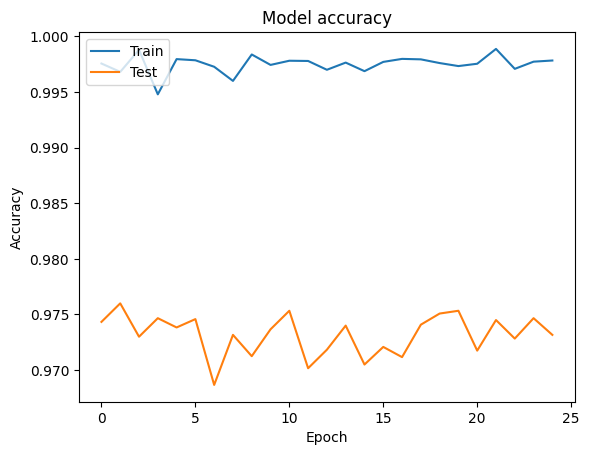

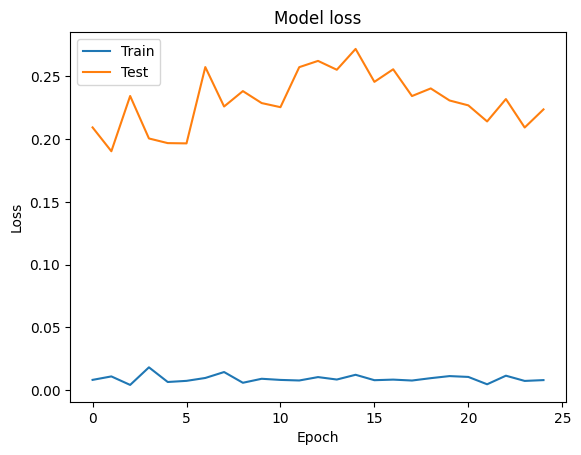

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation accuracy values for history_r
plt.plot(history_r.history['accuracy'])
plt.plot(history_r.history['val_accuracy'])

# Plot training & validation accuracy values for history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test (history_r)', 'Test (history)'], loc='upper left')
plt.show()